# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/My Drive/Colab Notebooks/train_32x32.mat')
test = loadmat('/content/gdrive/My Drive/Colab Notebooks/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

In [ ]:
# My import library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
import random

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
X_train = train['X']
y_train = train['y']

X_test = test['X']
y_test = test['y']

In [ ]:
# taking a look at the shapes of our data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

The shapes above represent (width, height, channels, # of images). Generally, if we index X_train (i.e. X_train[n], where n between 0 and 73527), we want an entire image. If we perform this code with the given order we will fail to do so and obtain the height/width of each image instead. So let us reorganize these numpy arrays

In [ ]:
X_train = X_train.transpose((3,0,1,2))
X_test = X_test.transpose((3,0,1,2))

# checking shape
X_train.shape, X_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3))

Now the shapes match up. Let's check the labels


In [ ]:
y_train.shape, y_test.shape

((73257, 1), (26032, 1))

Similar to the features, when we index the label (i.e. y_train[n]) we want to obtain the label immediately, which does not occur with the way the label is currently organized to let's quickly reshape the label

In [ ]:
y_train = y_train[:,0]
y_test = y_test[:, 0]
y_train.shape, y_test.shape

((73257,), (26032,))

Now creating a function to plot these images for us. For convenience, let's make this function work for both RGB and grayscale. This function will take the entirety of the training set and use given indexes to obtain the image.

In [ ]:
def plot_image(image, labels, indexes):
    # RGB
    if (image[0].shape == (32,32,3)):
        for index in indexes:
            plt.figure()
            plt.imshow(image[index])
            plt.title(labels[index])
            plt.show()
    # grayscale
    else:
        for index in indexes:
            plt.figure()
            plt.imshow(image[index, :,:,0])
            plt.title(labels[index])
            plt.show()

Obtaining 10 random numbers for our possible indexes now

In [ ]:
index_list = random.sample(range(0, max(X_train.shape)), 10)
index_list

[43072, 38896, 47428, 11762, 34561, 22408, 49405, 1892, 35646, 32052]

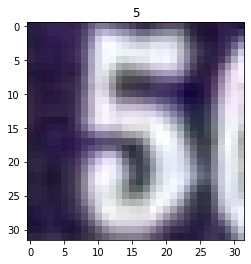

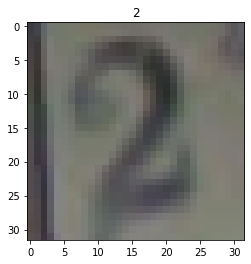

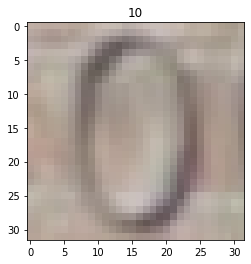

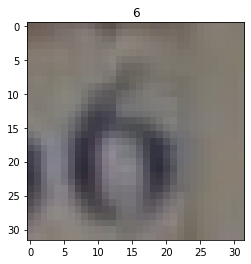

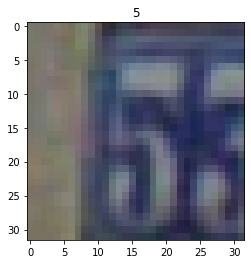

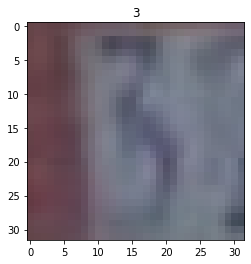

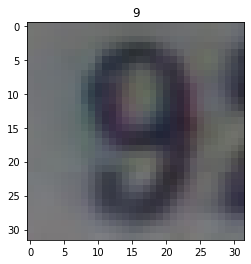

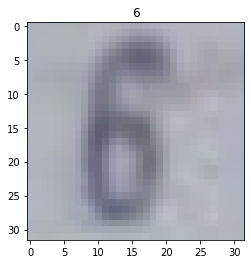

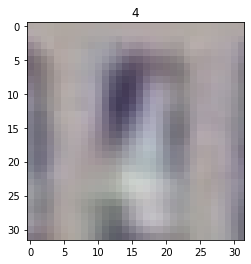

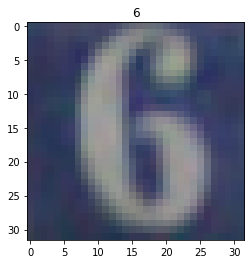

In [ ]:
plot_image(X_train, y_train, index_list)

Doing the same but in grayscale now. (Note that the constants for grayscale are different from simply taking the average of all the RGB values and using the method above will not result in a proper grayscaled image)

In [ ]:
def rgb_to_gray(images):
    return np.expand_dims(np.dot(images, [1/3, 1/3, 1/3]), axis=3)

In [ ]:
X_train_gray = rgb_to_gray(X_train)
X_test_gray = rgb_to_gray(X_test)

# deleting previous RGB files
del X_train, X_test


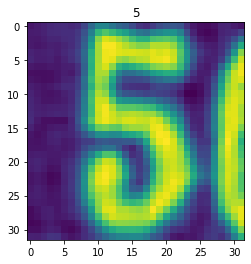

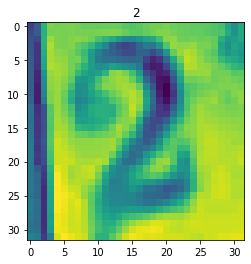

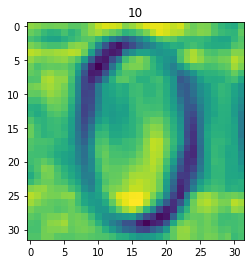

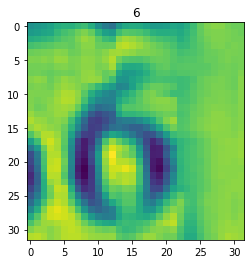

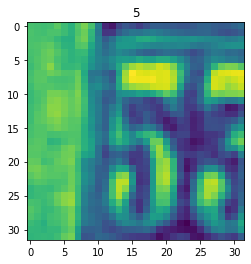

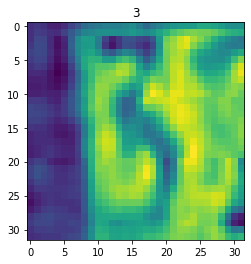

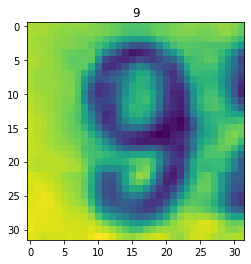

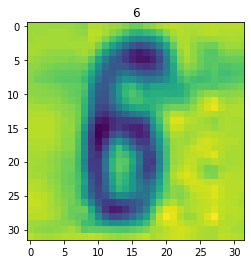

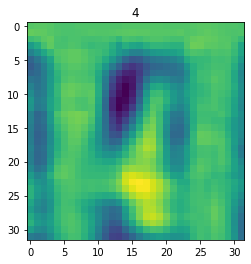

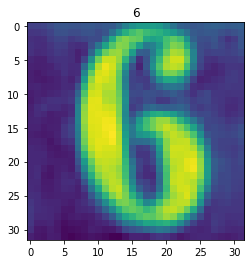

In [ ]:
plot_image(X_train_gray, y_train, index_list)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
def get_model_MLP(input_shape):
    model = Sequential([
        Flatten(input_shape = input_shape),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(11, activation = 'softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_early_stopping():
    result = EarlyStopping(monitor = 'val_accuracy', patience = 3, mode = 'auto')
    return result

def get_best_checkpoint_MLP():
    checkpoint = ModelCheckpoint(filepath =  'best_checkpoint_MLP/checkpoint',
                             save_weights_only = True,
                             verbose = 1,
                             monitor = 'val_accuracy',
                             save_best_only = True)
    return checkpoint
  
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

def get_test_loss(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('loss: {acc:0.3f}'.format(acc=test_loss))



In [ ]:
model_MLP = get_model_MLP(X_train_gray[0].shape)
early_stopping = get_early_stopping()
best_checkpoint_MLP = get_best_checkpoint_MLP()
model_MLP.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32, 32, 128)       256       
_________________________________________________________________
dense_26 (Dense)             (None, 32, 32, 128)       16512     
_________________________________________________________________
flatten_6 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8388672   
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 11)                363       
Total params: 8,407,883
Trainable params: 8,407,883
Non-trainable params: 0
____________________________________________

In [ ]:
call_history_MLP = model_MLP.fit(X_train_gray, y_train, epochs = 5, validation_split = 0.2, 
         callbacks = [early_stopping, best_checkpoint_MLP], verbose = 1, batch_size = 1000)

Epoch 1/5
59/59 [==============================] - ETA: 0s - loss: 42.4581 - accuracy: 0.0943
Epoch 00001: val_accuracy improved from -inf to 0.11787, saving model to best_checkpoint_MLP/checkpoint
59/59 [==============================] - 260s 4s/step - loss: 42.4581 - accuracy: 0.0943 - val_loss: 2.3916 - val_accuracy: 0.1179
Epoch 2/5
59/59 [==============================] - ETA: 0s - loss: 2.3744 - accuracy: 0.1793
Epoch 00002: val_accuracy improved from 0.11787 to 0.18748, saving model to best_checkpoint_MLP/checkpoint
59/59 [==============================] - 256s 4s/step - loss: 2.3744 - accuracy: 0.1793 - val_loss: 2.3523 - val_accuracy: 0.1875
Epoch 3/5
59/59 [==============================] - ETA: 0s - loss: 2.3256 - accuracy: 0.1896
Epoch 00003: val_accuracy did not improve from 0.18748
59/59 [==============================] - 254s 4s/step - loss: 2.3256 - accuracy: 0.1896 - val_loss: 2.2989 - val_accuracy: 0.1875
Epoch 4/5
59/59 [==============================] - ETA: 0s - lo

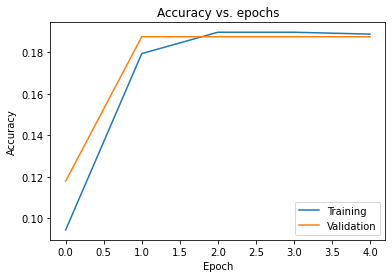

In [ ]:
try:
    plt.plot(call_history_MLP.history['accuracy'])
    plt.plot(call_history_MLP.history['val_accuracy'])
except KeyError:
    plt.plot(call_history_MLP.history['acc'])
    plt.plot(call_history_MLP.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

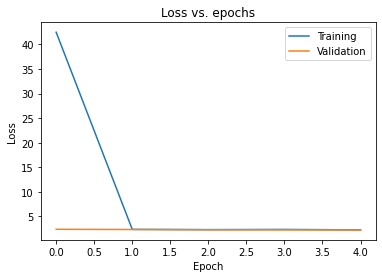

In [ ]:
plt.plot(call_history_MLP.history['loss'])
plt.plot(call_history_MLP.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
get_test_accuracy(model_MLP, X_test_gray, y_test), get_test_loss(model_MLP, X_test_gray, y_test)

KeyboardInterrupt: ignored

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [1]:
def get_model_CNN(input_shape):
  model = Sequential([
        Conv2D(16, (4,4), activation = 'relu', padding = 'SAME', input_shape = input_shape),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(8, (4,4), activation = 'relu', padding = 'SAME', input_shape = input_shape),
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.1),
        Dense(32, activation = 'relu'),
        Dense(10, activation = 'softmax')
  ])
  model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  return model

def get_best_checkpoint_CNN():
    checkpoint = ModelCheckpoint(filepath =  'best_checkpoint_CNN/checkpoint',
                             save_weights_only = True,
                             verbose = 1,
                             monitor = 'val_accuracy',
                             save_best_only = True)
    return checkpoint

In [ ]:
model_CNN = get_model_CNN(X_train_gray[0].shape)
early_stopping = get_early_stopping()
best_checkpoint_CNN = get_best_checkpoint_CNN()
model_CNN.summary()

In [ ]:
call_history_CNN = model_CNN.fit(X_train_gray, y_train, epochs = 5, validation_split = 0.2, 
         callbacks = [early_stopping, best_checkpoint_CNN], verbose = 1, batch_size = 1000)

In [ ]:
try:
    plt.plot(call_history_CNN.history['accuracy'])
    plt.plot(call_history_CNN.history['val_accuracy'])
except KeyError:
    plt.plot(call_history_CNN.history['acc'])
    plt.plot(call_history_CNN.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [ ]:
plt.plot(call_history_CNN.history['loss'])
plt.plot(call_history_CNN.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
get_test_accuracy(model_CNN, X_test_gray, y_test), get_test_loss(model_CNN, X_test_gray, y_test)

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
def get_model_MLP_best_epoch(model):
    best_epoch = tf.train.latest_checkpoint("best_checkpoint_MLP")
    model.load_weights(best_epoch)
    return model
  
def get_model_CNN_best_epoch(model):
    best_epoch = tf.train.latest_checkpoint("best_checkpoint_CNN")
    model.load_weights(best_epoch)
    return model

# MLP
best_MLP = get_model_MLP_best_epoch(get_model_MLP(X_train_gray[0].shape))
# CNN
best_CNN = get_model_CNN_best_epoch(get_model_CNN(X_train_gray[0].shape))

In [ ]:
index_list = random.sample(range(0, max(X_test_gray.shape)), 5)

In [ ]:
numbers = [1,2,3,4,5,6,7,8,9,10]
for index in index_list:
  plt.figure()
  plt.imshow(X_test_gray[index, :,:,0])
  plt.title(y_test[index])
  plt.show()

  # MLP predictions
  prediction_distr_MLP = best_MLP.predict([X_test_gray[index]])
  predict_MLP = max(prediction_distr_MLP)
  plt.bar(numbers, prediction_distr_MLP)
  plt.title('MLP Prediction Distribution')
  print("Final MLP prediction: %f" % (predict_MLP))

  # CNN predictions
  prediction_distr_CNN = best_CNN.predict([X_test_gray[index]])
  predict_CNN = max(prediction_distr_CNN)
  plt.bar(numbers, prediction_distr_CNN)
  plt.title('CNN Prediction Distribution')
  print("Final CNN prediction: %f" % (predict_CNN))
  

In [ ]:
X_test_gray.shape